This notebook is a simplified version of https://github.com/aspuru-guzik-group/GA. See Nigam et al., 2020.

In [1]:
import pandas as pd
import selfies as slf
import numpy as np
from rdkit.Chem import Descriptors
from rdkit import Chem
import rdkit
import tqdm
import matplotlib.pyplot as plt
import matplotlib

rdkit.RDLogger.DisableLog('rdApp.*')

print("pandas\t", pd.__version__)
print("numpy\t", np.__version__)
print("rdkit\t", rdkit.__version__)
print("selfies\t", slf.__version__)
print("tqdm\t", tqdm.__version__)
print("matplotlib\t", matplotlib.__version__)

pandas	 2.1.1
numpy	 1.26.0
rdkit	 2023.03.3
selfies	 2.0.0
tqdm	 4.66.1
matplotlib	 3.8.0


In [2]:
# Get dataset
# Tox21 data: Qualitative toxicity measurements on 12 biological targets, 
#             including nuclear receptors and stress response pathways [classification]
url = (
    "https://raw.githubusercontent.com/GLambard/Molecules_Dataset_Collection/master/latest/tox21.csv"
)
dataset = pd.read_csv(url)
dataset.head()

,Unnamed: 0,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles
0,0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX3021,CCOC1:C:C:C2:N:C(S(N)(=O)=O):S:C:2:C:1
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3020,CCN1C(=O)NC(C2:C:C:C:C:C:2)C1=O
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX3024,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3027,CCCN(CC)C(CC)C(=O)NC1:C(C):C:C:C:C:1C
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX20800,CC(O)(P(=O)(O)O)P(=O)(O)O


In [3]:
# We will use SELFIES representation for molecules, since it is 100% valid under any perturbations.
# First, we define "alphabet" of the molecules.

# transform to SELFIES
selfies_strings = dataset.smiles.apply(slf.encoder)

# "alphabet" is a set of tokens
alphabet = list(slf.get_alphabet_from_selfies(selfies_strings))

In [4]:
# We will use logP as a fitness score (high logP = high lipophilicity).

def _safe_logP(mol):
    try: 
        score = Descriptors.MolLogP(mol)
    except: # invalid molecule
        score = -1
    return score


def evaluate_fitness(selfies):
    fitness = []
    for selfie in selfies:
        smi = slf.decoder(selfie)
        mol = Chem.MolFromSmiles(smi)
        fitness += [_safe_logP(mol)]
    return np.array(fitness)

evaluate_fitness(selfies_strings[:4])

array([1.3424 , 1.2994 , 5.0903 , 3.75244])

In [5]:
# Select molecules to be replaced according to fitness score
# We replace low fitness molecules to mutations of higher fitness molecules.

def select_molecules(fitness):
    # scale rank and pass to sigmoid function
    rank = np.argsort(np.argsort(fitness))
    z = 5 * rank / len(rank) - 2
    probabilities = 1 / (1 + np.exp(-z))
    
    to_replace = [] # all molecules that are replaced 
    to_keep    = [] # all molecules that are kept 
    for idx in range(len(rank)):
        if np.random.rand(1) > probabilities[idx]:
            to_replace.append(idx)
        else:
            to_keep.append(idx)
    return to_replace, to_keep

select_molecules([1, 2, 3, 4, 5])

([0, 1, 3], [2, 4])

In [6]:
# Mutation rule: 50% insertions or 50% replacements of single SELFIES characters.

def _is_valid(smi):
    # Although SELFIES is 100% "valid", it includes
    # a "empty molecule" which is not a real substance.
    try:
        mol = Chem.MolFromSmiles(smi, sanitize=True)
        smi = Chem.MolToSmiles(mol, isomericSmiles=False, canonical=True)
        if len(smi) == 0:
            return False
        else:
            return True
    except:
        return False


def random_mutation(selfie, alphabet=alphabet):
    chars_selfie = list(slf.split_selfies(selfie))
    valid = False
    for _ in range(30): # loop until the mutated SELFIES string is valid
        # Insert a character in a Random Location
        if np.random.random() < 0.5: 
            random_index = np.random.randint(len(chars_selfie)+1)
            random_character = np.random.choice(alphabet, size=1)[0]
    
            selfie_mutated_chars = chars_selfie[:random_index] + [random_character] + chars_selfie[random_index:]
    
        # Replace a random character 
        else:                         
            random_index = np.random.randint(len(chars_selfie))
            random_character = np.random.choice(alphabet, size=1)[0]
            selfie_mutated_chars = chars_selfie[:random_index] + [random_character] + chars_selfie[random_index+1:]

        selfie_mutated = ''.join(selfie_mutated_chars)
        smiles = slf.decoder(selfie_mutated)
        if _is_valid(smiles):
            break

    return selfie_mutated


def replace_next_gen_molecules(population, to_replace, to_keep):
    for idx in to_replace:
        # smiles to replace (by better molecules)
        random_index=np.random.choice(to_keep, size=1)[0]    # select a random molecule that survived
        population[idx] = random_mutation(population[random_index])  # do the mutation (inplace)
    return population

selfie = selfies_strings[19]

print("original", selfie)
print("mutated ", random_mutation(selfie, alphabet))

original [C][C][O][C][=Branch1][C][=O][C][=C][C][=C][N][=C][Ring1][=Branch1]
mutated  [C][C][O][C][=Branch1][C][=O][C][=C][\O][=C][N][=C][Ring1][=Branch1]


100%|█████████████████████████████████| 50/50 [00:32<00:00,  1.55it/s, fitness=25.6]


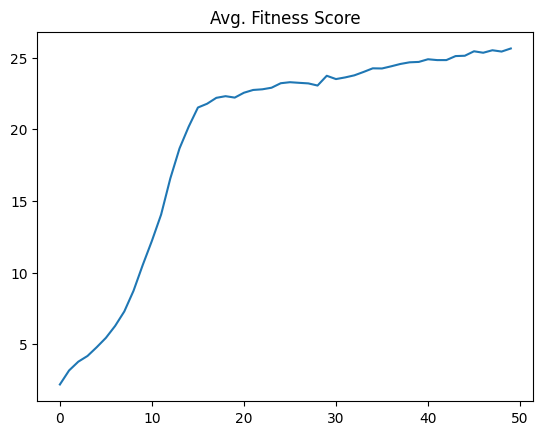

In [7]:
# population size: 500
population = dataset.smiles[:500].apply(slf.encoder).to_list()

avg_fit = []
pbar = tqdm.trange(50)

for _ in pbar:
    fitness = evaluate_fitness(population)
    to_replace, to_keep = select_molecules(fitness)
    population = replace_next_gen_molecules(population, to_replace, to_keep)

    avg_fit.append(np.mean(fitness))
    pbar.set_postfix({"fitness": avg_fit[-1]})

plt.title("Avg. Fitness Score")
plt.plot(avg_fit)
plt.show()

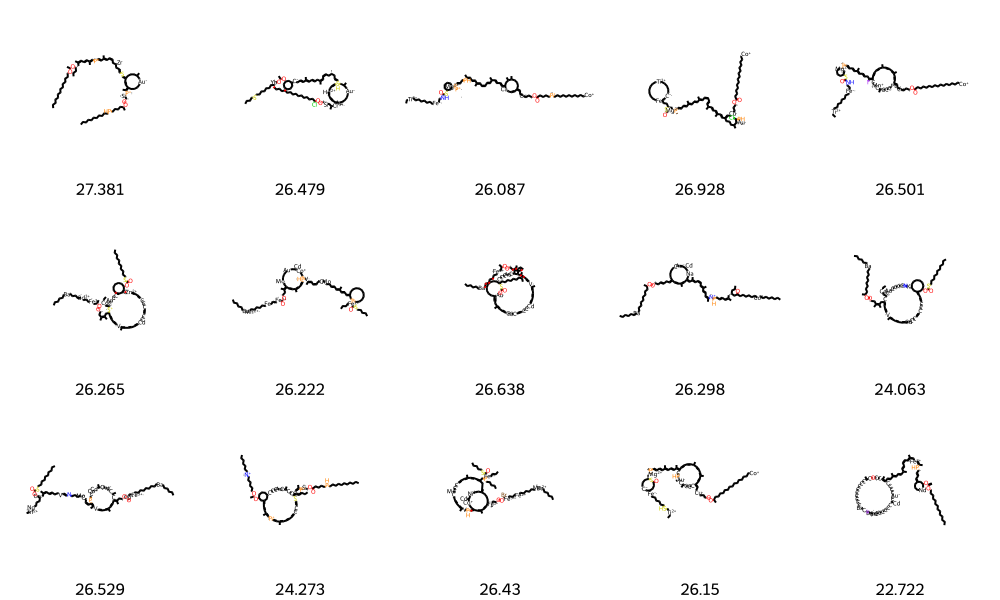

In [8]:
# Note that logP can be optimized without bound, which can result in unrealistic molecules.
smiles = [slf.decoder(selfie) for selfie in population]
mols = [Chem.MolFromSmiles(smi) for smi in smiles]
legends = [str(round(x, 3)) for x in evaluate_fitness(population[:24])]

Chem.Draw.MolsToGridImage(mols[:15], molsPerRow=5, legends=legends)

# Reference

Nigam et al., Augmenting genetic algorithms with deep neural networks for exploring the chemical space, ICLR, 2020.